##Import Libreries

In [ ]:
from torchvision import datasets
import numpy as np
from torchvision import transforms
from torch.utils.data import ConcatDataset
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch.nn as nn
from tqdm import trange
from torchvision.models import alexnet
import torch.nn as nn
import torch.optim as optim
from google.colab import drive
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torchvision.models as models




## Data Augmentation
Here, I used data augmentation, and since the data consists of images, zero-centering was applied. Also, for the training data, CIFAR-10-like augmentations were used, including:
ShearX, ShearY, TranslateX, TranslateY, Rotate, AutoContrast, Invert, Equalize, Solarize, Posterize, Contrast, Color, Brightness, Sharpness, Cutout



In [ ]:
transform_train=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[1.0]), #zero-center
    transforms.AutoAugmentPolicy.CIFAR10,
    transforms.Resize((224, 224))



])

transform_test=transform_train=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[1.0]), #zero-center
    transforms.Resize((224, 224))



])

These augmentations were applied, and the augmented data was concatenated with the original data.

In [ ]:
cifar_train_aug=datasets.CIFAR10(root='./data',train=True,
                             download=True,transform=transform_train)

In [ ]:
cifar_train_org=datasets.CIFAR10(root='./data',train=True,
                             download=True,transform=transform_test)

cifar_train=ConcatDataset([cifar_train_aug,cifar_train_org])

In [ ]:
cifar_test=datasets.CIFAR10(root='./data',train=False,
                             download=True,transform=transform_test)

In [ ]:
from torch.utils.data import random_split
test_size=int(0.8*len(cifar_test))
valid_size=int(len(cifar_test))-test_size
cifar_valid,cifar_test=random_split(cifar_test,[valid_size,test_size])

In [ ]:
from torch.utils.data import DataLoader
train_loader=DataLoader(cifar_train,shuffle=True,batch_size=8)
test_loader=DataLoader(cifar_test,shuffle=True,batch_size=8)
valid_loader=DataLoader(cifar_valid,shuffle=True,batch_size=8)

In [ ]:
classes = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]


In [ ]:
device=torch.device('cuda'if torch.cuda.is_available() else 'cpu')
device


device(type='cuda')

## Visualizing some examples from the dataset and Class distribution

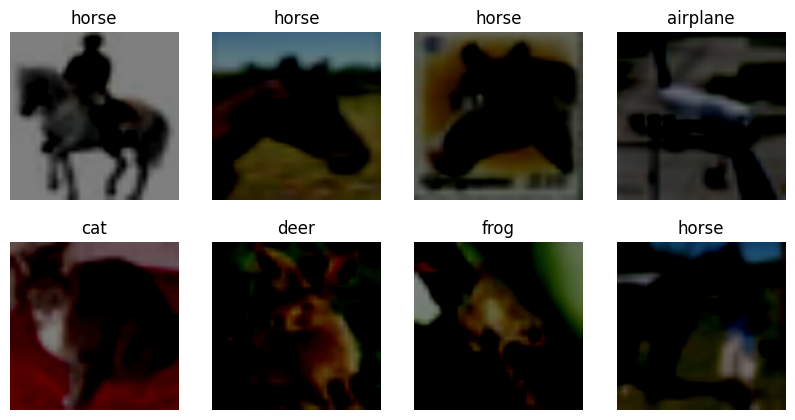

In [ ]:

imgs,label=next(iter(train_loader))

fig,axis=plt.subplots(2,4,figsize=(10,5))
for i,ax in enumerate(axis.flat):
  img=imgs[i].permute(1,2,0)
  ax.imshow(img,cmap='gray')
  ax.set_title(classes[int(label[i])])
  ax.axis('off')


As we can see, we have a reasonable amount of data from each class and there is no issue.

Text(0.5, 1.0, 'valid')

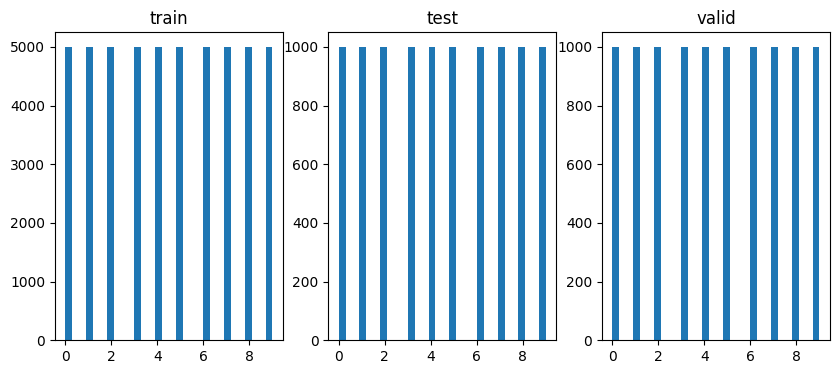

In [ ]:

fig,ax=plt.subplots(1,3,figsize=(10,4))



labels_train = torch.tensor(cifar_train_org.targets)
ax[0].hist(labels_train, bins=30);
ax[0].set_title('train')

labels_test = torch.tensor(cifar_test.dataset.targets)
ax[1].hist(labels_test, bins=30);
ax[1].set_title('test')


labels_valid = torch.tensor(cifar_valid.dataset.targets)
ax[2].hist(labels_valid, bins=30);
ax[2].set_title('valid')



## Detecting outlier data

Since t-SNE did not produce good results in some cases, we use an encoder-decoder model instead. This is because this network learns based on the entire dataset. If there is an outlier data point, it will not be properly reconstructed during decoding and will differ significantly from the original sample.

In [ ]:

train_images = torch.stack([cifar_train[i][0] for i in range(int(len(cifar_train)/100))])
train_images_flat = train_images.view(train_images.size(0), -1).numpy()
tsne = TSNE(n_components=2, perplexity=30, random_state=0)
features_2d = tsne.fit_transform(train_images_flat)



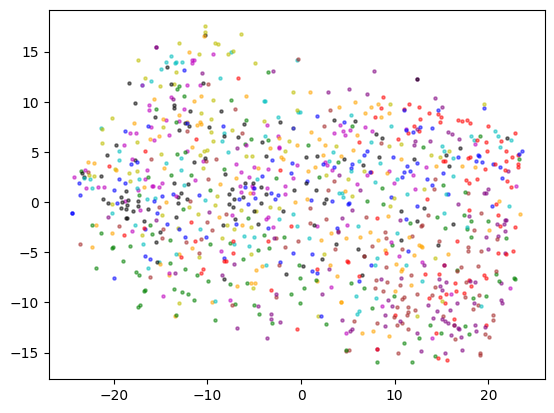

In [ ]:

labels = torch.tensor([cifar_train[i][1] for i in range(int(len(cifar_train)/10))])
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown']

for i in range(len(features_2d)):
    plt.scatter(features_2d[i, 0], features_2d[i, 1], color=colors[labels[i]], s=5, alpha=0.5)


In [ ]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, output_padding=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, output_padding=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out


In [ ]:
model=ConvAutoencoder().to(device)
loss_fn=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=1e-3)

In [ ]:
for epoch in trange(10):
  model.train()
  for images,_ in train_loader:
    images=images.to(device)
    output=model(images)
    loss=loss_fn(output,images)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()


100%|██████████| 10/10 [26:57<00:00, 161.76s/it]


In [ ]:
reconstruction_errors = []
original_images = []

model.eval()

with torch.no_grad():
  for image,_ in train_loader:
    output=model(image)
    loss2 = ((output - images) ** 2).view(images.size(0), -1).mean(dim=1) #MSE loss function
    reconstruction_errors.extend(loss2.cpu().numpy())
    original_images.extend(images.cpu())


In [ ]:

reconstruction_errors = np.array(reconstruction_errors)
original_images = torch.stack(original_images)

outlier_loss=reconstruction_errors[reconstruction_errors > 0.95]
outlier_image=original_images[reconstruction_errors > 0.95]
outlier_image

tensor([], size=(0, 3, 32, 32))

tensor([], size=(0, 3, 32, 32))

## Practical functions

In [ ]:
def train_model(model,optim,loss_fn,train_loader,epochs):
  loss_list=[]
  model.train()
  for epoch in trange(epochs):
    for images,labels in train_loader:
      img,label=images.to(device),labels.to(device)
      predict=model(img)
      loss=loss_fn(predict,label)
      loss.backward()
      optim.step()
      optim.zero_grad()
    loss_list.append(loss)


  return loss_list






In [ ]:
def test_model(model, test_loader, device=device):
    model.eval()
    corect = 0
    total = 0
    all_labels = []
    predict=[]


    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            corect += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            predict.extend(predicted.cpu().numpy())


    return corect,total,predict,all_labels


In [ ]:


def confusing(data,classes,model,name):
  corect,total,predict,label=test_model(model , data)
  cm = confusion_matrix(label, predict)
  plt.figure(figsize=(6,6))
  sns.heatmap(cm, cmap=plt.cm.Blues,
                xticklabels=classes, yticklabels=classes)
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.title(f"Accuracy_{name}:{100 * corect / total}")
  plt.show()






In [ ]:


def visualize_first_conv_filters(model, num_filters=16):

    first_conv = model.features[0]
    weights = first_conv.weight.data.clone().cpu()

    n = min(num_filters, weights.shape[0])
    cols = 4
    rows = (n + cols - 1) // cols
    fig, axs = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))

    for i in range(rows * cols):
        ax = axs.flat[i]
        if i < n:
            img = weights[i].permute(1, 2, 0)  # (C, H, W) → (H, W, C)
            ax.imshow(img)
            ax.set_title(f'Filter {i}')
        ax.axis('off')

    plt.suptitle('First Conv Layer Filters')
    plt.tight_layout()
    plt.show()


I trained several models and also used pretrained models due to limited computational resources. In order to better understand the data distribution, I only made a few layers learnable during fine-tuning.

I also wrote a neural network from scratch (named "NIN") (Network in Network ), but did not train it. The reason was the need for a large number of epochs and significant training time, which I couldn't afford due to lack of hardware and resources.

However, the full code for the network is ready, and I also implemented a confusion matrix to evaluate it, as well as visualization of the first layer weights

## Alexnet

In [ ]:



model_alexnet=alexnet(pretrained=True)
model_alexnet.classifier[6]=nn.Linear(4096,10)
for param in model_alexnet.parameters():
    param.requires_grad = False

for param in model_alexnet.classifier[6].parameters():
    param.requires_grad = True

for param in model_alexnet.features[10].parameters():
    param.requires_grad = True



model_alexnet=model_alexnet.to(device)
optimizer_alexnet=optim.Adam(model_alexnet.parameters(),lr=1e-4)
loss_alexnet=criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:01<00:00, 194MB/s]


In [ ]:
model_alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
loss_alexnet=train_model(model_alexnet,optimizer_alexnet,loss_alexnet,train_loader,15)

100%|██████████| 15/15 [41:51<00:00, 167.41s/it]


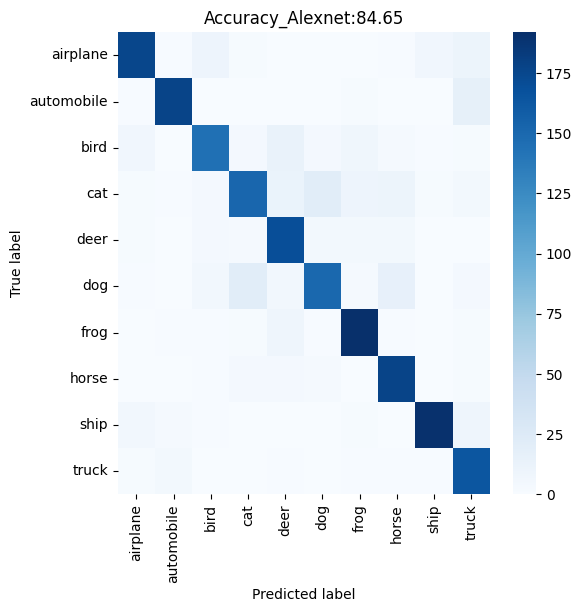

In [ ]:
confusing(valid_loader,classes,model_alexnet,'Alexnet')

In [ ]:
drive.mount('/content/drive')
torch.save(model_alexnet.state_dict(), '/content/drive/MyDrive/model_alexnet_cifar10.pth')


Mounted at /content/drive


In [ ]:
model_alexnet=alexnet(pretrained=True)
model_alexnet.classifier[6]=nn.Linear(4096,10)
for param in model_alexnet.parameters():
    param.requires_grad = False

for param in model_alexnet.classifier[6].parameters():
    param.requires_grad = True

for param in model_alexnet.features[10].parameters():
    param.requires_grad = True


model_alexnet.load_state_dict(torch.load('/content/drive/MyDrive/model_alexnet_cifar10.pth', map_location=device))


model_alexnet=model_alexnet.to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:02<00:00, 92.0MB/s]


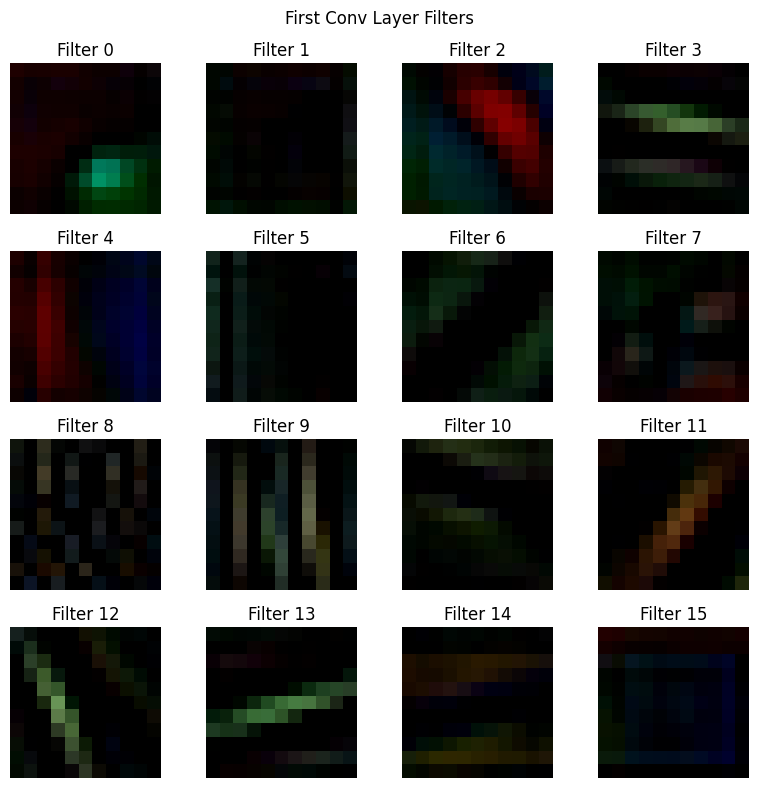

In [ ]:
visualize_first_conv_filters(model_alexnet)



## Resnet-18

In [ ]:

model_resnet18=models.resnet18(pretrained=True)




/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 205MB/s]


In [ ]:
model_resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
for param in model_resnet18.parameters():
    param.requires_grad = False


for param in model_resnet18.layer4.parameters():
    param.requires_grad = True

for param in model_resnet18.fc.parameters():
    param.requires_grad = True

model_resnet18.fc = nn.Linear(model_resnet18.fc.in_features, 10)


In [ ]:
optimizer_resnet18=optim.Adam(model_resnet18.parameters(),lr=1e-4)
loss_resnet18=criterion = nn.CrossEntropyLoss()

model_resnet18=model_resnet18.to(device)

loss_resnet18_list=train_model(model_resnet18,optimizer_resnet18,
                                       loss_resnet18,train_loader,15)



100%|██████████| 15/15 [54:56<00:00, 219.78s/it]


In [ ]:
torch.save(model_resnet18.state_dict(), 'model_resnet18_cifar10.pth')
drive.mount('/content/drive')
torch.save(model_resnet18.state_dict(), '/content/drive/MyDrive/model_resnet18_cifar10.pth')


Mounted at /content/drive


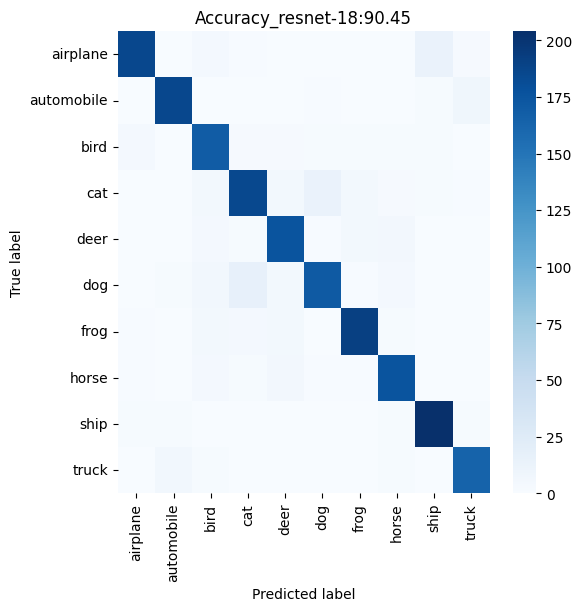

In [ ]:
confusing(valid_loader,classes,model_resnet18,'resnet-18')

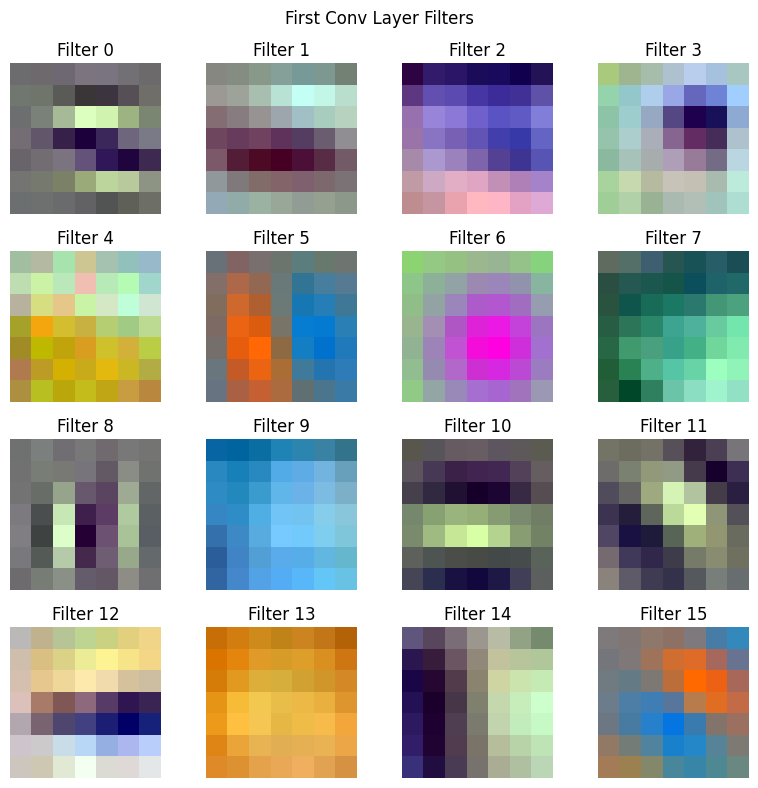

In [ ]:
#visualize_first_conv_filters(model_resnet18)


first_conv = model_resnet18.conv1
weights = first_conv.weight.data.clone().cpu()

n = min(16, weights.shape[0])
cols = 4
rows = (n + cols - 1) // cols
fig, axs = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))

for i in range(rows * cols):
        ax = axs.flat[i]
        if i < n:
            img = weights[i]
            img = (img - img.min()) / (img.max() - img.min())
            img = img.permute(1, 2, 0)
            ax.imshow(img)
            ax.set_title(f'Filter {i}')
        ax.axis('off')

plt.suptitle('First Conv Layer Filters')
plt.tight_layout()
plt.show()


In [ ]:
model_resnet18=models.resnet18(pretrained=True)
for param in model_resnet18.parameters():
    param.requires_grad = False


for param in model_resnet18.layer4.parameters():
    param.requires_grad = True

for param in model_resnet18.fc.parameters():
    param.requires_grad = True

model_resnet18.fc = nn.Linear(model_resnet18.fc.in_features, 10)


model_resnet18.load_state_dict(torch.load('/content/drive/MyDrive/model_resnet18_cifar10.pth', map_location=device))


<All keys matched successfully>

## mobile-net

In [ ]:
model_mobilenet=models.mobilenet_v3_small(pretrained=True)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


100%|██████████| 9.83M/9.83M [00:00<00:00, 130MB/s]


In [ ]:
model_mobilenet

In [ ]:
model_mobilenet.classifier[3]=nn.Linear(1024,10)
for param in model_mobilenet.parameters():
    param.requires_grad = False

for param in model_mobilenet.classifier[3].parameters():
    param.requires_grad = True

for param in model_mobilenet.features[10].parameters():
    param.requires_grad = True



model_mobilenet=model_mobilenet.to(device)
optimizer_mobilenet=optim.Adam(model_mobilenet.parameters(),lr=1e-4)
loss_mobilenet = nn.CrossEntropyLoss()

In [ ]:
loss_list_mobilenet=train_model(model_mobilenet,optimizer_mobilenet,
                                       loss_mobilenet,train_loader,10)


100%|██████████| 10/10 [42:24<00:00, 254.47s/it]


whith just 10 epochs we becomme this result!!!!! amazing

In [ ]:
cifar_train_aug=datasets.CIFAR10(root='./data',train=True,
                             download=True,transform=transform_train)

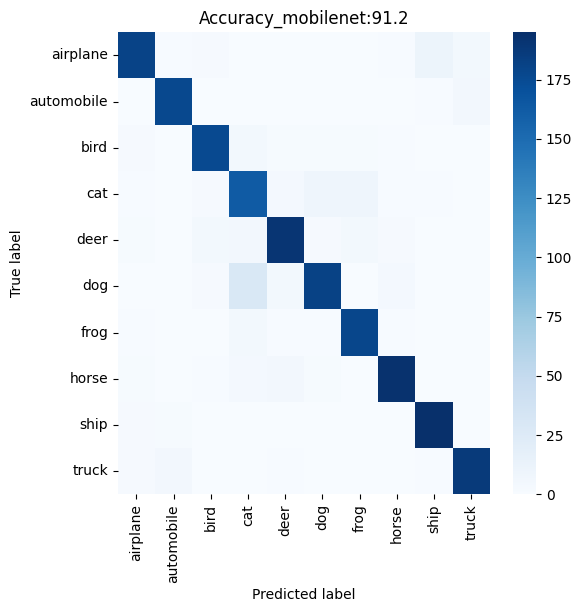

In [ ]:
confusing(valid_loader,classes,model_mobilenet,'mobilenet')

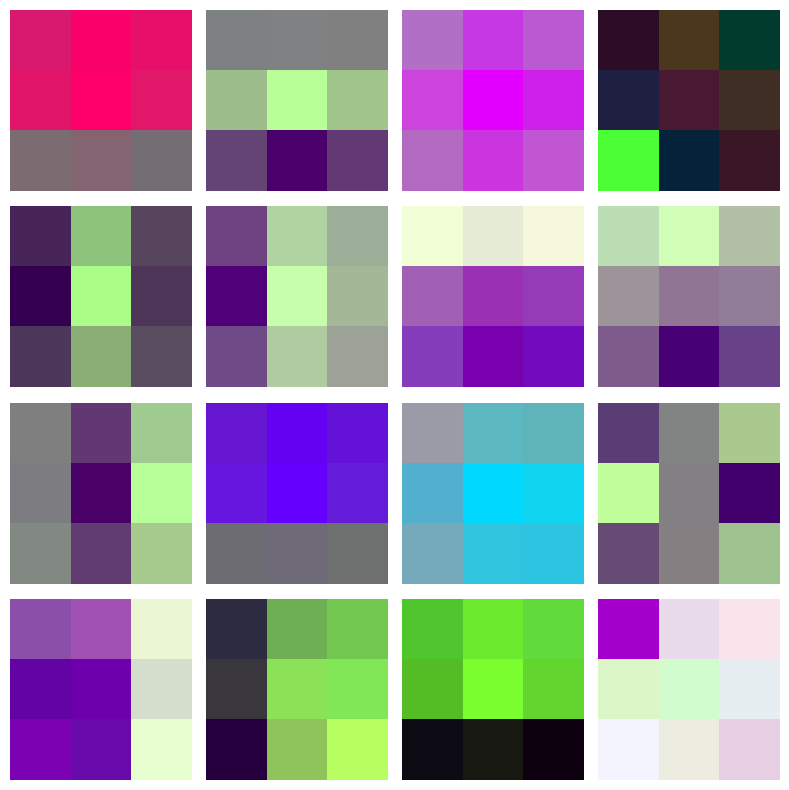

In [ ]:
import matplotlib.pyplot as plt

conv1 = model_mobilenet.features[0][0]
weights = conv1.weight.data.cpu()

num_filters = 16
plt.figure(figsize=(8, 8))

for i in range(num_filters):
    filter = weights[i]
    filter_img = filter.permute(1, 2, 0)

    filter_img = (filter_img - filter_img.min()) / (filter_img.max() - filter_img.min() + 1e-5)

    plt.subplot(4, 4, i + 1)
    plt.imshow(filter_img)
    plt.axis('off')

plt.tight_layout()
plt.show()


##Efficientnet

In [ ]:

model_efficient = models.efficientnet_b0(pretrained=True)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model_efficient

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
model_efficient.classifier= nn.Linear(1280, 10)

for param in model_efficient.parameters():
    param.requires_grad = False

for param in model_efficient.classifier.parameters():
    param.requires_grad = True

for param in model_efficient.features[6].parameters():
    param.requires_grad = True



model_efficient=model_efficient.to(device)
optimizer_efficient=optim.Adam(model_efficient.parameters(),lr=1e-4)
loss_efficient = nn.CrossEntropyLoss()

In [ ]:
loss_list_inception=train_model(model_efficient,optimizer_efficient,loss_efficient,
                                train_loader,15)


100%|██████████| 15/15 [1:27:12<00:00, 348.84s/it]


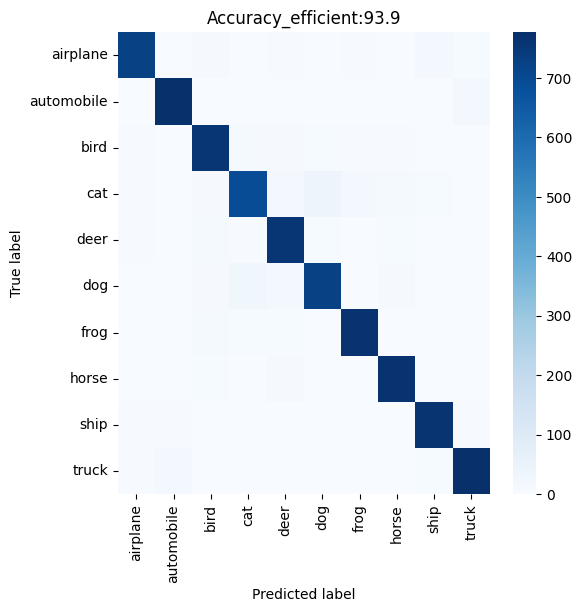

In [ ]:
confusing(valid_loader,classes,model_efficient,'efficient')

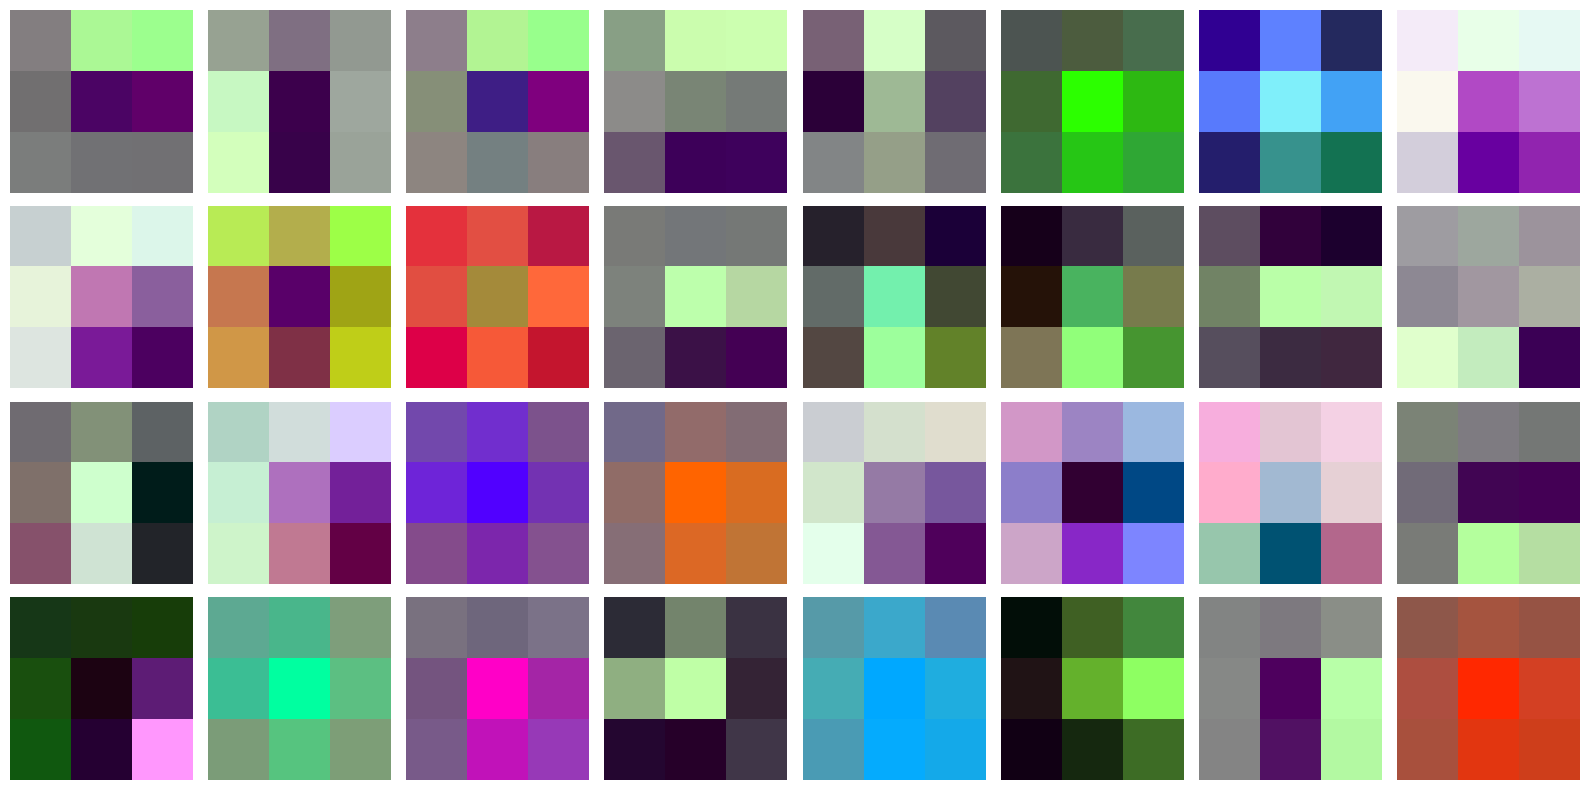

In [ ]:
model =model_efficient
conv1_weights = model.features[0][0].weight.data.cpu()
num_filters = conv1_weights.shape[0]
ncols = 8
nrows = int(np.ceil(num_filters / ncols))
plt.figure(figsize=(ncols * 2, nrows * 2))
for i in range(num_filters):
    ax = plt.subplot(nrows, ncols, i + 1)
    w = conv1_weights[i]
    w = (w - w.min()) / (w.max() - w.min())
    w = w.permute(1, 2, 0).numpy()
    ax.imshow(w)
    ax.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
drive.mount('/content/drive')
torch.save(model_efficient.state_dict(), '/content/drive/MyDrive/model_efficient_cifar10.pth')

Mounted at /content/drive


## Result and Summery

These models, despite some of them hiding input images and having a large number of parameters, were able to classify the data quite well because my dataset was CIFAR-10, which is one of the well-known datasets. Many modern models are trained on various datasets before being released, and one of these is CIFAR.
However, MobileNet and EfficientNet algorithms achieved higher accuracy because of their more complex architectures, which allow the model to engage more deeply with the data and understand it better.
ResNet-18, due to its more intelligent structure, was able to achieve better results compared to AlexNet.

In ResNet, residual connections are used to prevent the vanishing gradient problem.
In EfficientNet, compound scaling is applied to balance depth, width, and resolution of the network.


These reasons explain why these two models achieved better accuracy.

It was observed that in most networks, the model had difficulty distinguishing between dogs and cats. This is because, compared to other classes, dogs and cats have more visual similarities. In simpler terms, all classes are relatively distant from each other in feature space, except for cats and dogs, which are very close together.

This similarity often leads to classification errors. However, with deeper networks and training for more epochs, this issue can be effectively resolved.

In [ ]:
#confusing(test_loader,classes,model_efficient,'efficient')

## one interesting instruction (NIN)

In this model, I use entirely convolutional layers and it does not use FCP (fully connected perceptron), which is very interesting.

In [ ]:
class NIN(nn.Module):
    def __init__(self, num_classes):
        super(NIN, self).__init__()
        self.num_classes = num_classes

        self.features = nn.Sequential(
            nn.Conv2d(3, 192, 5, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 160, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(160, 96, 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2, ceil_mode=True),
            nn.Dropout(inplace=True),

            nn.Conv2d(96, 192, 5, padding=2),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(3, stride=2, ceil_mode=True),

            nn.Conv2d(192, 192, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, self.num_classes, 1),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )


    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), self.num_classes)
        return x


In [ ]:
model_nin=NIN(10)
optimizer_nin=optim.Adam(model_nin.parameters(),lr=1e-4)
loss_nin = nn.CrossEntropyLoss()

model_nin=model_nin.to(device)

loss_nin_list=train_model(model_nin,optimizer_nin,
                                       loss_nin,train_loader,15)